This model uses LSTM model to construct the deep learning process, studying the price and returns movements of CSI300, SP500 and DAX, in the time range of 2010-01-01 to 2021-11-15(will be updated).

In [ ]:
# In case in a new computer there is no packages, simply delete "#"
# pip install pandas
# pip install numpy
# pip install sklearn
# pip install keras
# pip install tensorflow
# pip install matplotlib

In [1]:
#import all the packages
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

I constructed some functions to be used in main() in the next cell

In [2]:
# Functions that return either Price or Return dataframe
def dfprice(dataframe):
    Price = dataframe.drop(dataframe.columns[[1]],axis = 1)
    return Price

def dfreturn(dataframe):
    Return = dataframe.drop(dataframe.columns[[0]], 1)
    return Return

# Plot function that will plot the prices or returns of the dataframe input
def price_plot(dataframe):
    Price = dfprice(dataframe)
    Price.columns.values[0] = "Price"
    Price.plot(figsize = (18, 8), linewidth = 2)
    plt.title("Adjusted Close Price of " + dataframe.name)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Adjusted Close Price USD($)', fontsize = 18)
    plt.show()

def return_plot(dataframe):
    Return = dfreturn(dataframe)
    Return.columns.values[0] = "Return"
    Return.plot(figsize = (18, 8), linewidth = 0.8)
    plt.title("Compound Return of " + dataframe.name)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Compound Return', fontsize = 18)
    plt.show()

# Define a function to scale the dataframe input
def Scaleddata(dataframe):
    dataset = dataframe.values
    scaler = MinMaxScaler(feature_range = (0,1))
    scaled_data = scaler.fit_transform(dataset)
    return scaled_data

# Split the data into training and testing dataset, notice that they cannot have mutual data.
def splitdata(dataframe):
    train, test = dataframe[:n_in], dataframe[n_in-60:]
    return train, test

# Plot test window data and result after learning
def plot_price_predict(dataframe, valid):
    valid.plot(figsize = (16,8))
    plt.title('Model of the price of the '+dataframe.name)
    plt.xlabel('Date', fontsize = 18)
    plt.ylabel('Adjusted Close Price USD($)', fontsize = 18)
    plt.show()
    
def plot_return_predict(dataframe, valid):
    valid.plot(figsize = (16,8))
    plt.title('Model of the return of the '+dataframe.name)
    plt.xlabel('Date', fontsize = 18)
    plt.ylabel('Return of '+dataframe.name, fontsize = 18)
    plt.show() 

First step: Read data and manipulation

In [3]:
data = pd.read_csv("C:/Users/Amadeus/Desktop/Market Indexes.csv")
data = data.set_index("Date")
CSI300 = data[["PCSI300", "YCSI300"]]
CSI300.name = "CSI300"
CSI300.columns = ["Price", "Return"]
SP500 = data[["PSP500", "YSP500"]]
SP500.name = "SP500"
SP500.columns = ["Price", "Return"]
DAX = data[["PDAX", "YDAX"]]
DAX.name = "DAX"
DAX.columns = ["Price", "Return"]

In [4]:
# State some arguments
n_in = math.ceil(len(DAX)*0.8) # training data, every single one before 2020-11-01 (excluding)

Construct main function. 
This four arguments of the main function are:
1. Dataframe
2. "Price" or "Return" (IMPORTANT: quotation mark "" should be kept as input)
3. The number of rounds you want to update your model (not necessary to be high because it if the model's loss function has easy-to-be-found global minima, you only waste your time because its gradient descent process will always be the same; but higher epochs increase the probability to find the global minima of the loss function, increasing the fitness of the model)
4. The number of days you want to predict after the final date of the dataset: This function, however, uses 60 days before the predicted day to find it, so after 60 days, the function begins to self-generate, making its accuracy horrible. It is adjustable but not necessary
The outcomes of the function is:
1. A plot for the whole dataset (specifically either Price or Return of one Market Index)
2. The Loss found in the test set, defining the accuracy of the model
3. A plot of the actual data and predicted data of the model in the test set
4. A plot of the forecasting data
The function also returns a dataframe of the forecasted data of the specified number of days

In [5]:
def main(dataframe1, index, n_updates, n_predict_days):
    if index == "Price":
        price_plot(dataframe1)
        dataframe = dfprice(dataframe1)
    if index == "Return":
        return_plot(dataframe1)
        dataframe = dfreturn(dataframe1)
        
    # Now we have dataframe as either Price or Return, we now want to scale the data, but we save the original one as unscaled
    unscaled_dataframe1 = dataframe.values
    unscaled_dataframe2 = dataframe
    dataframe = Scaleddata(dataframe)
    scaler = MinMaxScaler(feature_range = (0,1))
    scaled_data = scaler.fit_transform(unscaled_dataframe1)
    
    # We now want to split the dataframe into train and test sample
    test_size = len(data)-n_in
    train, test = splitdata(dataframe)
    
    # convert an array of values into a dataset matrix
    x_train = []
    y_train = []
    for i in range(60, len(train)):
        x_train.append(train[i-60:i,0])
        y_train.append(train[i,0])
    x_test = []
    y_test = unscaled_dataframe2.values[n_in:, :]
    for i in range(60, len(test)):
        x_test.append(test[i-60:i, 0])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    
    # Reshape the X datasets
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    # Construct the LSTM
    model = Sequential()
    model.add(LSTM(50,return_sequences = True, input_shape = (x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences = False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model.fit(x_train, y_train, batch_size = 1, epochs = n_updates)
    
    # Find the predictions and loss
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    print(rmse)
    
    # Visualize the forecasted and actual data in the test set
    Train = unscaled_dataframe2[:n_in]
    valid = unscaled_dataframe2[n_in:]
    valid['Predictions'] = predictions
    if index == "Price":
        plot_price_predict(dataframe1, valid)
    if index == "Return":
        plot_return_predict(dataframe1, valid)
    
    # Predict price and returns one day ahead of existing data
    # Seems unnecessary but that is the best way I can do for now, otherwise, it is really hard to construct for loop
    last_60_days = unscaled_dataframe2[-60:].values
    last_60_days_scaled = scaler.transform(last_60_days)
    X_test = []
    X_test.append(last_60_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    forecasting = []
    
    # This for loop generates the speicifed number of forecasted data and store it in a npdarray
    for l in range(1,n_predict_days):
        forecasting = np.append(forecasting, pred_price)
        last_60_days = np.append(last_60_days, pred_price)[-60:]
        last_60_days = last_60_days.reshape(-1,1)
        last_60_days_scaled = scaler.transform(last_60_days)
        X_test = []
        X_test.append(last_60_days_scaled)
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        pred_price = model.predict(X_test)
        pred_price = scaler.inverse_transform(pred_price)
    forecasting = np.append(forecasting, pred_price)
    
    # Turning the forecasted npdarray to a pandas dataframe, for plotting
    new_df = pd.DataFrame(forecasting, columns = ['Forecasted Price'])
    new_df['the Xth traing days'] = range(1, n_predict_days+1)
    new_df = new_df.set_index('the Xth traing days')
    
    # Plotting the forecasted data
    if index == "Price":
        new_df.plot(figsize = (18, 8))
        plt.title('Prediction Price of the '+dataframe1.name)
        plt.xlabel('Xth date trading days', fontsize = 18)
        plt.ylabel('Predicting Price of '+dataframe1.name, fontsize = 18)
        plt.show() 
    if index == "Return":
        new_df.plot(figsize = (18, 8))
        plt.title('Prediction Return of the '+dataframe1.name)
        plt.xlabel('Xth date trading days', fontsize = 18)
        plt.ylabel('Predicting Return of '+dataframe1.name, fontsize = 18)
        plt.show() 
    
    return new_df # Returning the dataframe of the specified number of forecasted days

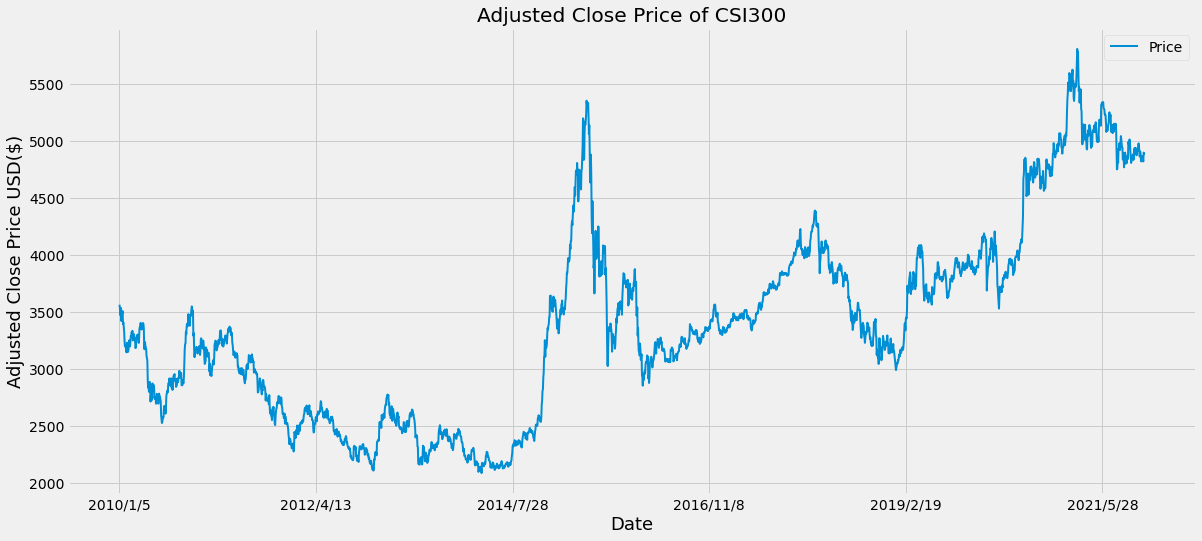

Epoch 1/100
2027/2027 [==============================] - 38s 18ms/step - loss: 0.0016
Epoch 2/100
2027/2027 [==============================] - 34s 17ms/step - loss: 6.6629e-04 10s - loss: 6. - ETA: 10s - loss -  - ETA: 7s - ET
Epoch 3/100
2027/2027 [==============================] - 33s 16ms/step - loss: 5.1804e-04
Epoch 4/100
2027/2027 [==============================] - 33s 16ms/step - loss: 3.6670e-04 3s - loss: 3.5479e  - ETA
Epoch 5/100
2027/2027 [==============================] - 33s 16ms/step - loss: 4.4945e-04 9s - loss: 4 - ETA: 9s - loss: 4.7510 - ETA: 8s - l - - ETA: 4s
Epoch 6/100
2027/2027 [==============================] - 33s 16ms/step - loss: 4.1454e-04
Epoch 7/100
2027/2027 [==============================] - 33s 16ms/step - loss: 3.9119e-04
Epoch 8/100
2027/2027 [==============================] - 33s 16ms/step - loss: 3.7216e-04 8s - l - ETA: 8
Epoch 9/100
2027/2027 [==============================] - 33s 16ms/step - loss: 3.3179e-04
Epoch 10/100
2027/2027 [=============

2027/2027 [==============================] - 32s 16ms/step - loss: 2.4102e-04
Epoch 81/100
2027/2027 [==============================] - 32s 16ms/step - loss: 2.3962e-04
Epoch 82/100
2027/2027 [==============================] - 35s 17ms/step - loss: 2.4022e-04 0s - loss
Epoch 83/100
2027/2027 [==============================] - 33s 16ms/step - loss: 2.3638e-04
Epoch 84/100
2027/2027 [==============================] - 32s 16ms/step - loss: 2.3857e-04
Epoch 85/100
2027/2027 [==============================] - 33s 16ms/step - loss: 2.3402e-04 8s - loss: 2. - ETA: 7s - l - ETA: 7s - ETA: 5s - l 
Epoch 86/100
2027/2027 [==============================] - 32s 16ms/step - loss: 2.4728e-04
Epoch 87/100
2027/2027 [==============================] - 32s 16ms/step - loss: 2.4106e-04
Epoch 88/100
2027/2027 [==============================] - 32s 16ms/step - loss: 2.4611e-04
Epoch 89/100
2027/2027 [==============================] - 33s 16ms/step - loss: 3.2914e-04
Epoch 90/100
2027/2027 [================

<ipython-input-5-0f88bb993a91>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


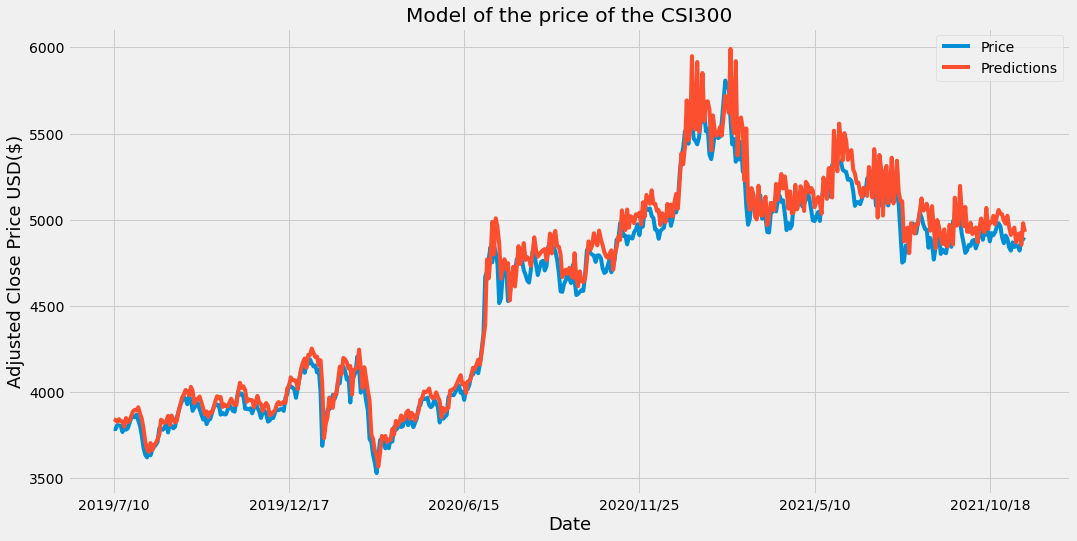

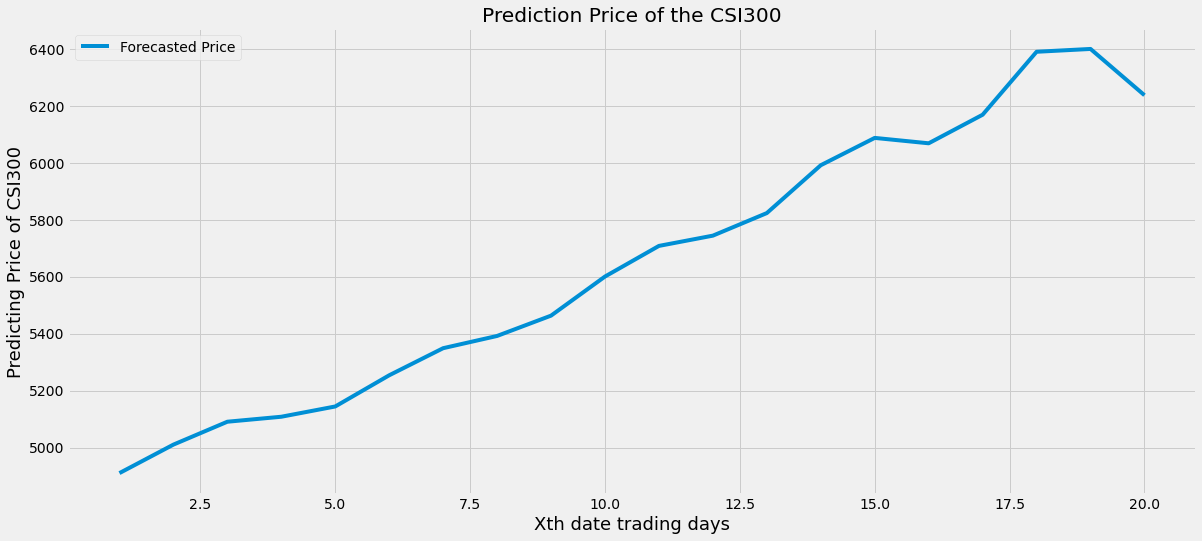

In [7]:
CSI300_Price_20_days_prediction = main(CSI300, 'Price', 100, 20)

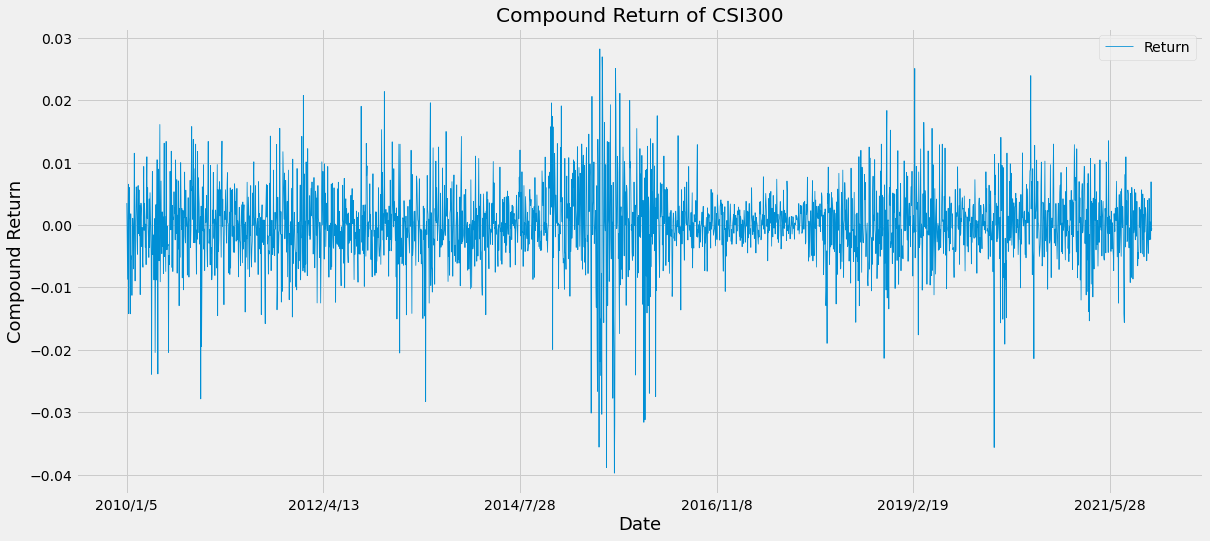

Epoch 1/100
2027/2027 [==============================] - 34s 16ms/step - loss: 0.0112
Epoch 2/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0098
Epoch 3/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0096
Epoch 4/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0096
Epoch 5/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0094
Epoch 6/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0094 0s - loss:
Epoch 7/100
2027/2027 [==============================] - 33s 16ms/step - loss: 0.0094
Epoch 8/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0094
Epoch 9/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0094
Epoch 10/100
2027/2027 [==============================] - 33s 16ms/step - loss: 0.0093 2s - - ETA: 1 - ETA: 
Epoch 11/100
2027/2027 [==============================] - 33s 16ms/step - loss: 0.0093
Epoch 12/100
2027/2

2027/2027 [==============================] - 34s 17ms/step - loss: 0.0091
Epoch 91/100
2027/2027 [==============================] - 33s 16ms/step - loss: 0.0091
Epoch 92/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0091 0s
Epoch 93/100
2027/2027 [==============================] - 33s 16ms/step - loss: 0.0091
Epoch 94/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0091
Epoch 95/100
2027/2027 [==============================] - 33s 16ms/step - loss: 0.0091A: 0s - loss: 0.0
Epoch 96/100
2027/2027 [==============================] - 33s 16ms/step - loss: 0.0091 0s - loss
Epoch 97/100
2027/2027 [==============================] - 33s 16ms/step - loss: 0.0091 1s - ETA: 0s - lo
Epoch 98/100
2027/2027 [==============================] - 33s 16ms/step - loss: 0.0091 2s - - ETA - ETA: 1s - loss: 0.00 - ETA: 0
Epoch 99/100
2027/2027 [==============================] - 33s 16ms/step - loss: 0.0091 7s  - ETA: 5s - loss - ETA:  - ETA: 
Epoch 100/100
2

<ipython-input-5-0f88bb993a91>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


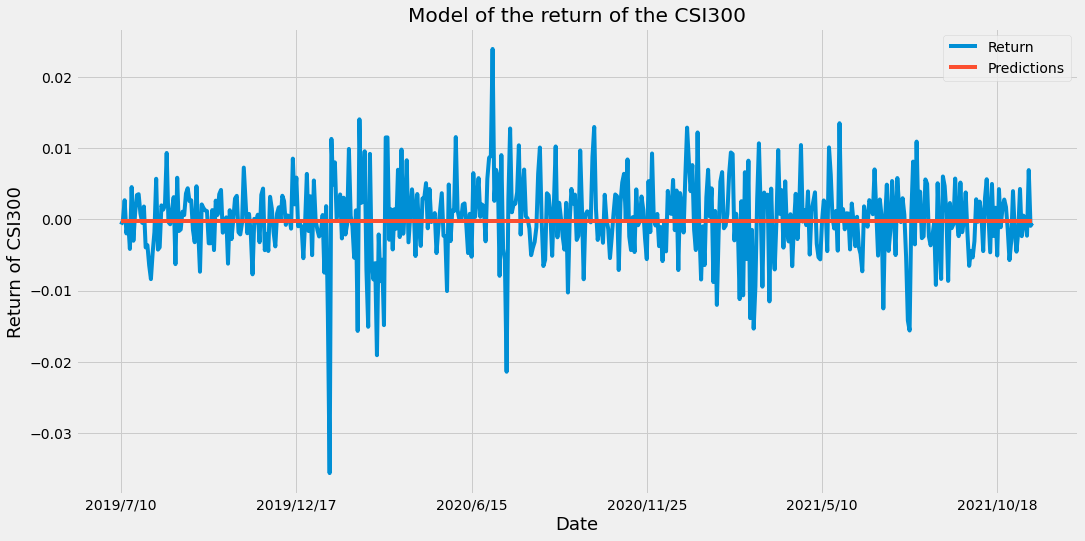

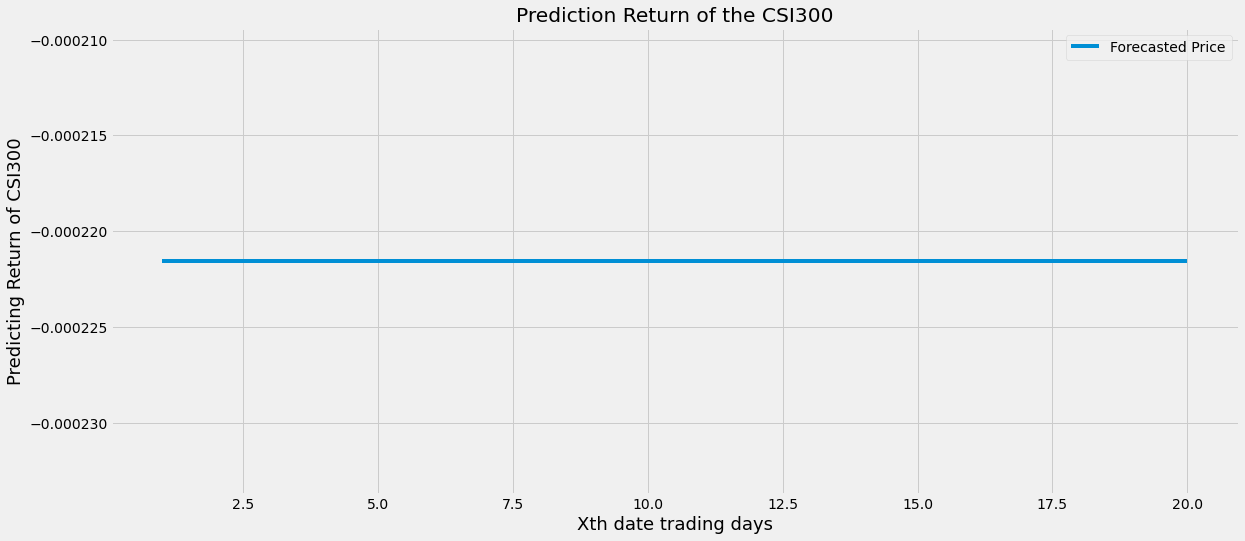

In [6]:
CSI300_Return_20_days_prediction = main(CSI300, 'Return', 100, 20)

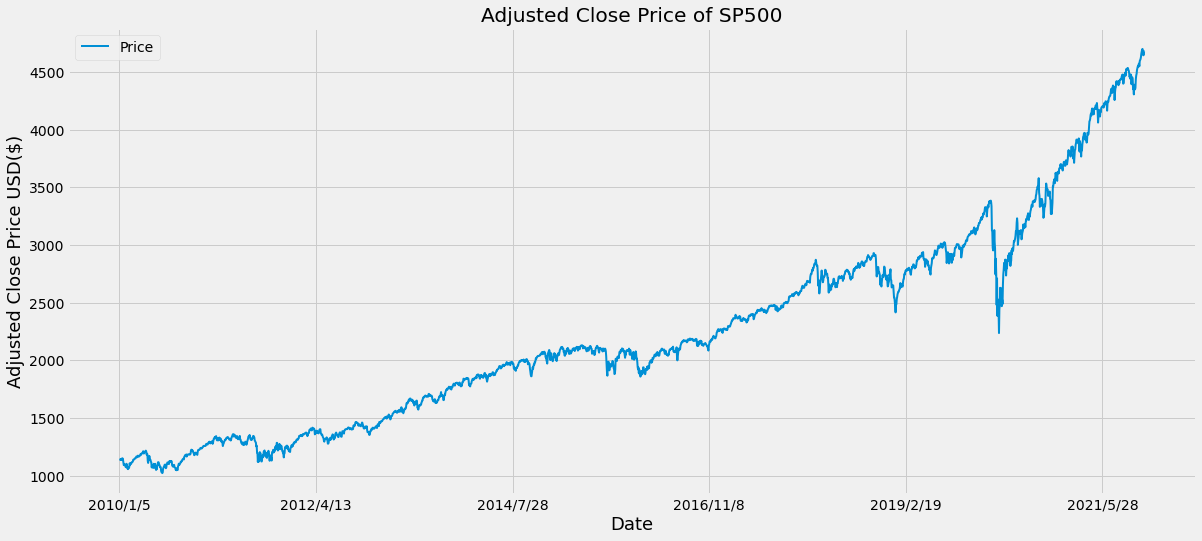

Epoch 1/100
2027/2027 [==============================] - 34s 16ms/step - loss: 4.1253e-04 1s - loss - ETA: 1
Epoch 2/100
2027/2027 [==============================] - 31s 15ms/step - loss: 1.6010e-04 0s - loss: 1.604
Epoch 3/100
2027/2027 [==============================] - 32s 16ms/step - loss: 1.4467e-04 8s - loss: 1.5 - ETA: 7s - lo - ETA: 7s - loss: 1.45 - ETA:
Epoch 4/100
2027/2027 [==============================] - 32s 16ms/step - loss: 1.0055e-04
Epoch 5/100
2027/2027 [==============================] - 32s 16ms/step - loss: 9.5414e-05 7s - loss: 9.3196e
Epoch 6/100
2027/2027 [==============================] - 32s 16ms/step - loss: 8.5009e-05
Epoch 7/100
2027/2027 [==============================] - 32s 16ms/step - loss: 8.8707e-05 4s
Epoch 8/100
2027/2027 [==============================] - 31s 15ms/step - loss: 7.5390e-05
Epoch 9/100
2027/2027 [==============================] - 32s 16ms/step - loss: 7.1809e-05 5s - loss: 6 - ETA: 4s - loss: 6.6  - ETA: 0s - los - ETA: 0s - loss: 7.

2027/2027 [==============================] - 33s 16ms/step - loss: 4.1524e-05 5s - l - ETA: 1s 
Epoch 69/100
2027/2027 [==============================] - 33s 16ms/step - loss: 3.9460e-05 0s - loss: 3
Epoch 70/100
2027/2027 [==============================] - 33s 16ms/step - loss: 4.3044e-05TA: 1s - loss - ETA: 0s - loss: 4.2757e - ETA: 0s - loss: 4
Epoch 71/100
2027/2027 [==============================] - 32s 16ms/step - loss: 4.1542e-05 1s - loss:  - ETA: 0s -
Epoch 72/100
2027/2027 [==============================] - 33s 16ms/step - loss: 4.1787e-05- ETA: 0s - loss: 4.1 - ETA: 0s - loss: 4.163
Epoch 73/100
2027/2027 [==============================] - 33s 16ms/step - loss: 4.1325e-05 0s - loss: 4.1258e-
Epoch 74/100
2027/2027 [==============================] - 33s 16ms/step - loss: 4.2060e-05: 0s - loss
Epoch 75/100
2027/2027 [==============================] - 32s 16ms/step - loss: 4.3705e-05 0s - loss:
Epoch 76/100
2027/2027 [==============================] - 33s 16ms/step - loss: 4.08

<ipython-input-5-0f88bb993a91>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


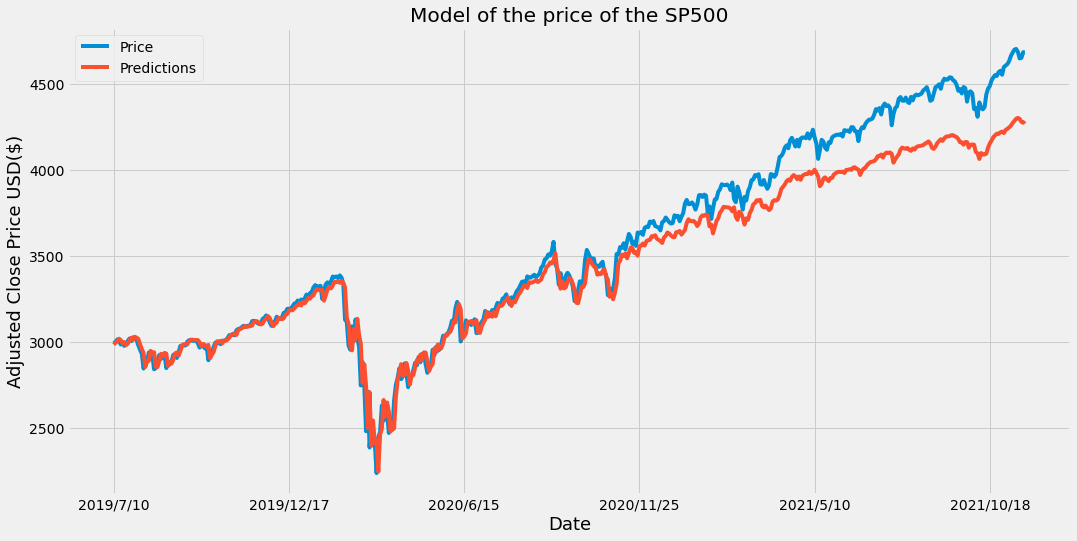

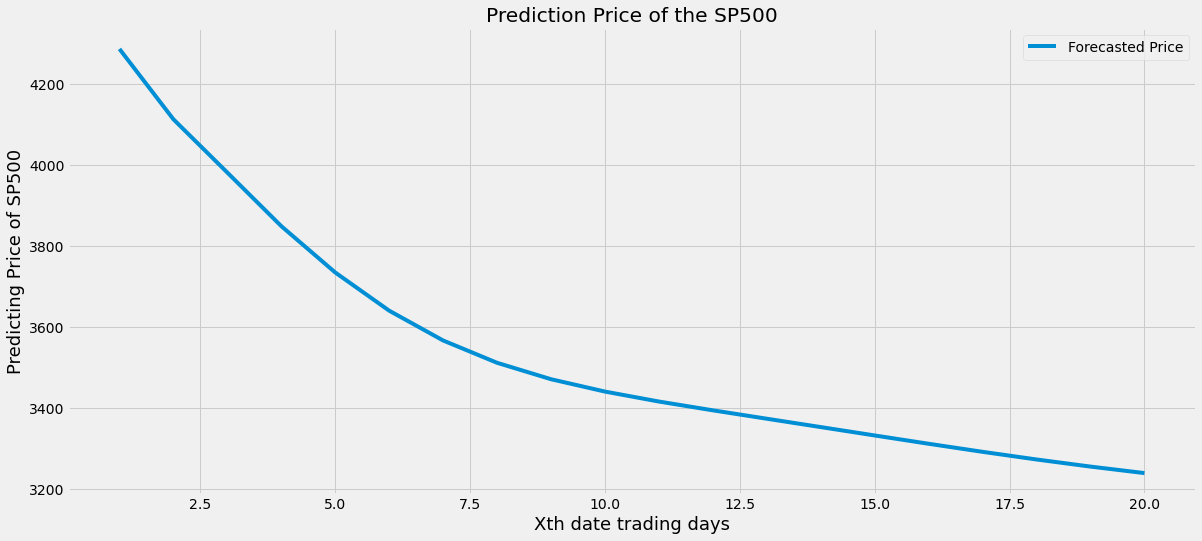

In [8]:
SP500_Price_20_days_prediction = main(SP500, 'Price', 100, 20)

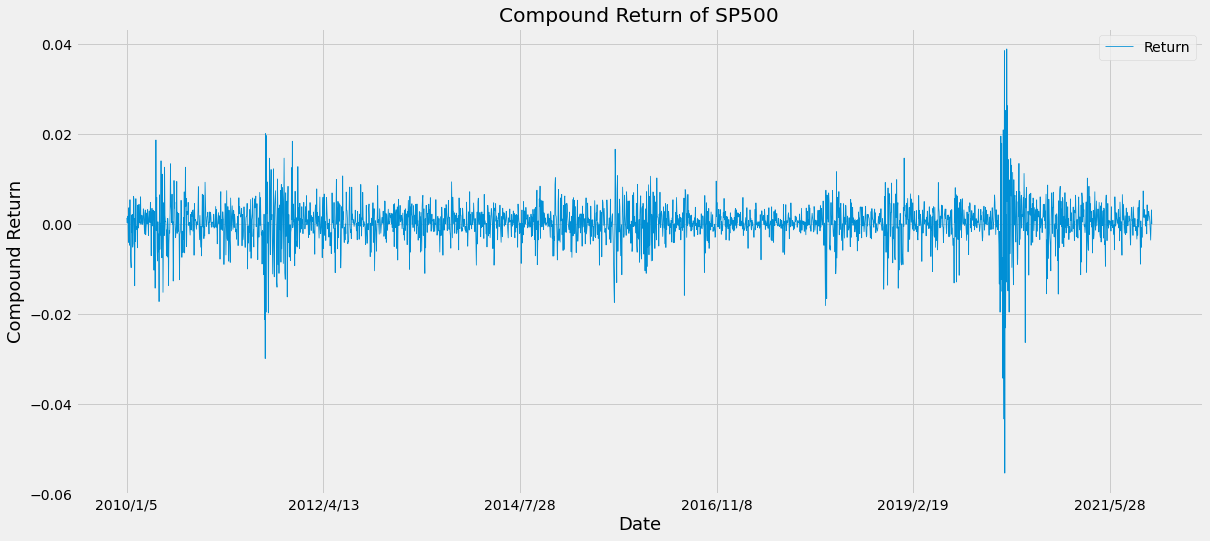

Epoch 1/100
2027/2027 [==============================] - 34s 16ms/step - loss: 0.0032 9s - loss:  - ET - ETA: 4s - lo - ETA: 4s - loss - ETA: 3s -  
Epoch 2/100
2027/2027 [==============================] - 33s 16ms/step - loss: 0.0023 0s - loss
Epoch 3/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0022
Epoch 4/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0021
Epoch 5/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0021
Epoch 6/100
2027/2027 [==============================] - 33s 16ms/step - loss: 0.0021
Epoch 7/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0021
Epoch 8/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0020
Epoch 9/100
2027/2027 [==============================] - 33s 16ms/step - loss: 0.0020
Epoch 10/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0021 0s 
Epoch 11/100
2027/2027 [==============================] - 33s 

2027/2027 [==============================] - 31s 15ms/step - loss: 0.0019
Epoch 82/100
2027/2027 [==============================] - 31s 15ms/step - loss: 0.0020
Epoch 83/100
2027/2027 [==============================] - 31s 16ms/step - loss: 0.0019
Epoch 84/100
2027/2027 [==============================] - 31s 15ms/step - loss: 0.0019
Epoch 85/100
2027/2027 [==============================] - 31s 15ms/step - loss: 0.0019
Epoch 86/100
2027/2027 [==============================] - 31s 15ms/step - loss: 0.0020 0s - l
Epoch 87/100
2027/2027 [==============================] - 31s 15ms/step - loss: 0.0020
Epoch 88/100
2027/2027 [==============================] - 31s 16ms/step - loss: 0.0019
Epoch 89/100
2027/2027 [==============================] - 31s 15ms/step - loss: 0.0020
Epoch 90/100
2027/2027 [==============================] - 31s 15ms/step - loss: 0.0020
Epoch 91/100
2027/2027 [==============================] - 31s 15ms/step - loss: 0.0019
Epoch 92/100
2027/2027 [=========================

<ipython-input-5-0f88bb993a91>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


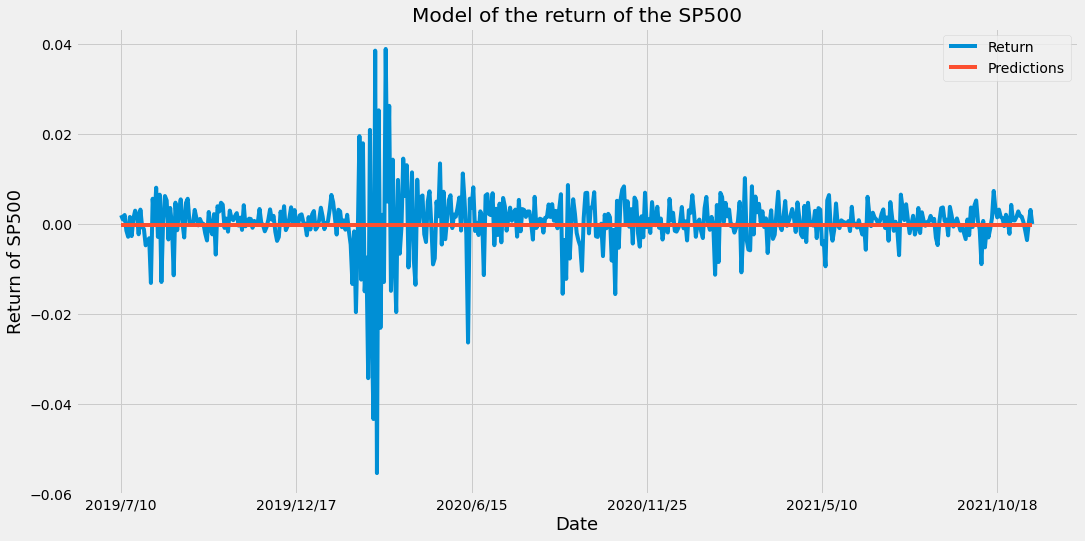

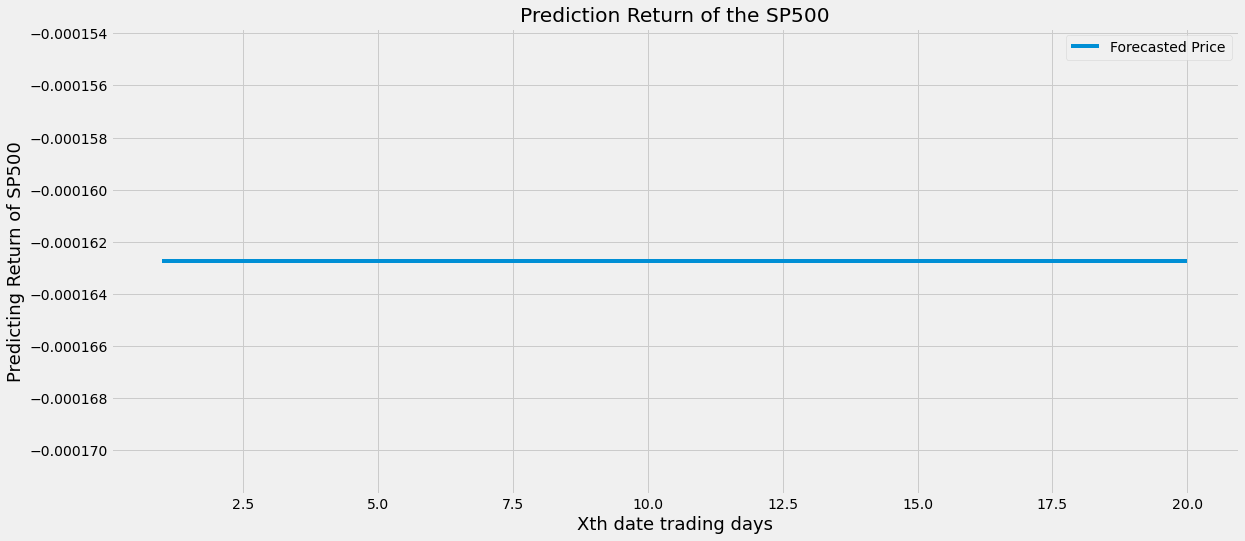

In [9]:
SP500_Return_20_days_prediction = main(SP500, 'Return', 100, 20)

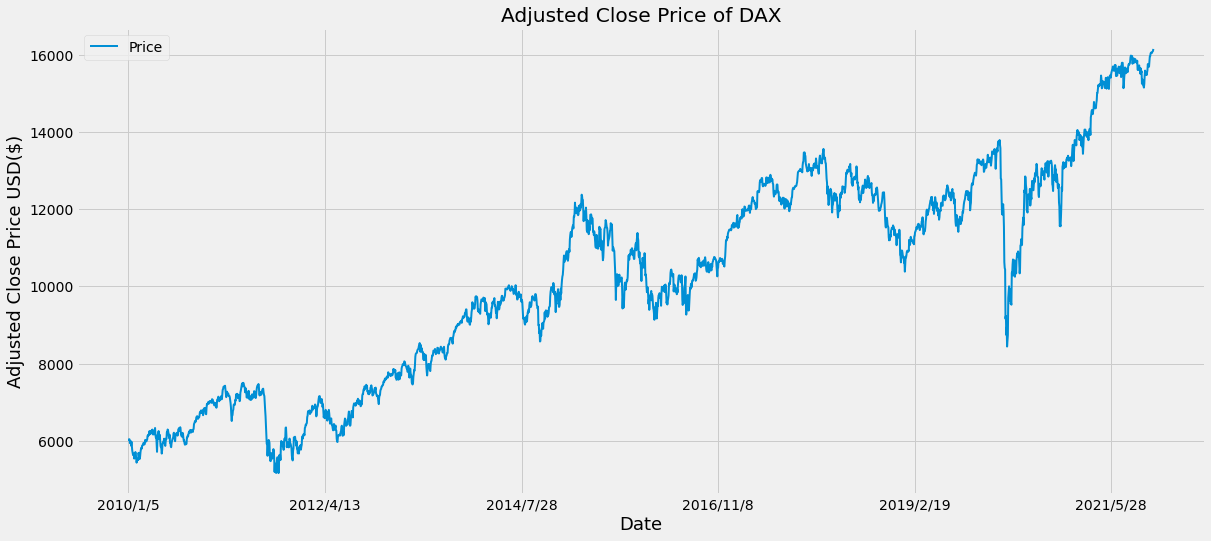

Epoch 1/100
2027/2027 [==============================] - 34s 16ms/step - loss: 0.0013 6s - loss: 0.00 -  - ETA: 5s  - ETA: 1s - loss: 0 - ETA: 0s
Epoch 2/100
2027/2027 [==============================] - 31s 15ms/step - loss: 4.9622e-04 9s - loss:  - ETA: 9s - loss: 5.2 - E - ET - ETA: 3s - loss: 5.042  - ETA: 1s - loss: 4.92 - ETA: 1s - loss: 5.0105e-0 - ETA: 1s - l - ETA: 0s - loss: 4.9667 - ETA: 0s - loss: 4.96
Epoch 3/100
2027/2027 [==============================] - 31s 15ms/step - loss: 3.4183e-04
Epoch 4/100
2027/2027 [==============================] - 32s 16ms/step - loss: 2.7253e-04 6s -  - ETA: 5s - loss: 2.6732e - ETA: 5s - loss: 2.6786e - E
Epoch 5/100
2027/2027 [==============================] - 31s 15ms/step - loss: 2.5947e-04 5 - ETA: 0s - loss: 2.5 - ETA: 0s - loss: 2.60
Epoch 6/100
2027/2027 [==============================] - 32s 16ms/step - loss: 2.5270e-04 0s - loss: 2.5124e
Epoch 7/100
2027/2027 [==============================] - 32s 16ms/step - loss: 2.5125e-04ETA: 1

2027/2027 [==============================] - 32s 16ms/step - loss: 1.5093e-04
Epoch 71/100
2027/2027 [==============================] - 32s 16ms/step - loss: 1.5310e-04 8s - loss:  - ETA: 4s -  - ETA: 3s - los - ETA: 2s - lo
Epoch 72/100
2027/2027 [==============================] - 32s 16ms/step - loss: 1.5546e-04
Epoch 73/100
2027/2027 [==============================] - 32s 16ms/step - loss: 1.5223e-04
Epoch 74/100
2027/2027 [==============================] - 32s 16ms/step - loss: 1.4948e-04 2s - lo
Epoch 75/100
2027/2027 [==============================] - 32s 16ms/step - loss: 1.4905e-04
Epoch 76/100
2027/2027 [==============================] - 32s 16ms/step - loss: 1.5041e-04
Epoch 77/100
2027/2027 [==============================] - 33s 16ms/step - loss: 1.5197e-04 2s  -
Epoch 78/100
2027/2027 [==============================] - 32s 16ms/step - loss: 1.5300e-04 1s - loss: - ETA: 1s -
Epoch 79/100
2027/2027 [==============================] - 33s 16ms/step - loss: 1.4767e-04 11s - los 

<ipython-input-5-0f88bb993a91>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


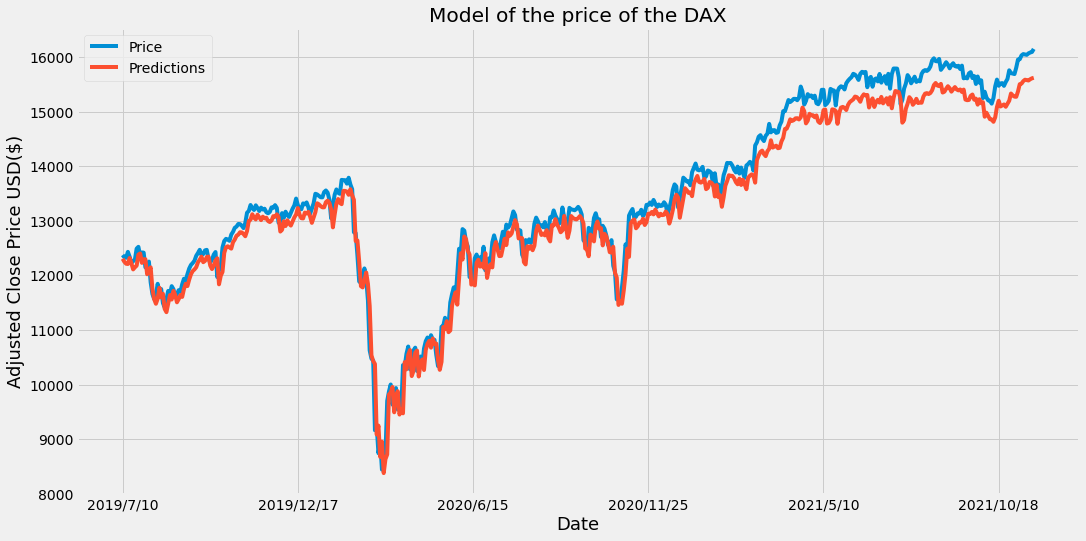

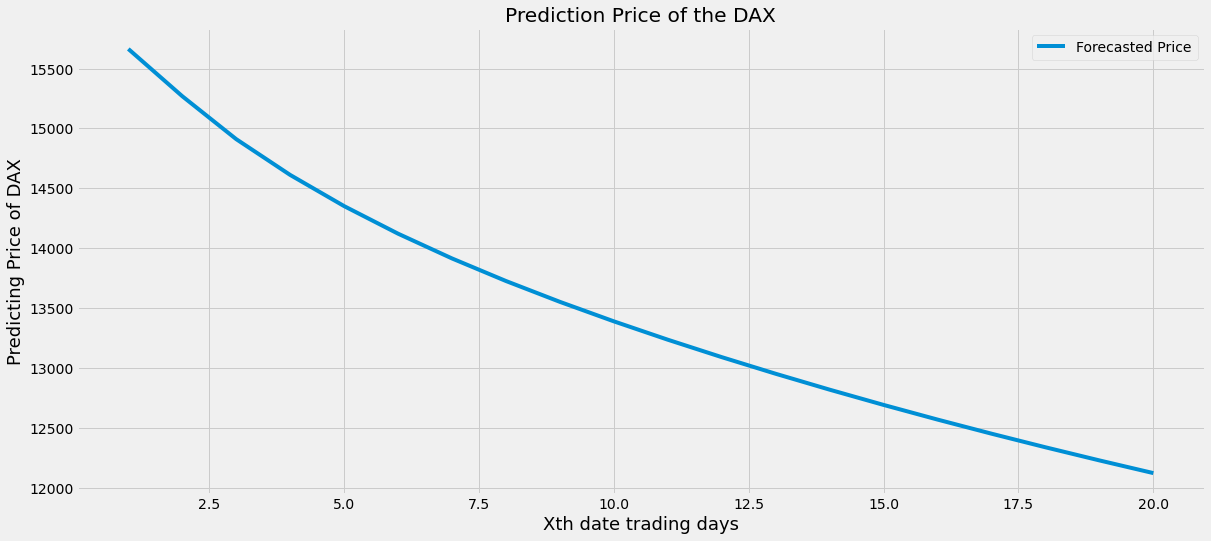

In [10]:
DAX_Price_20_days_prediction = main(DAX, 'Price', 100, 20)

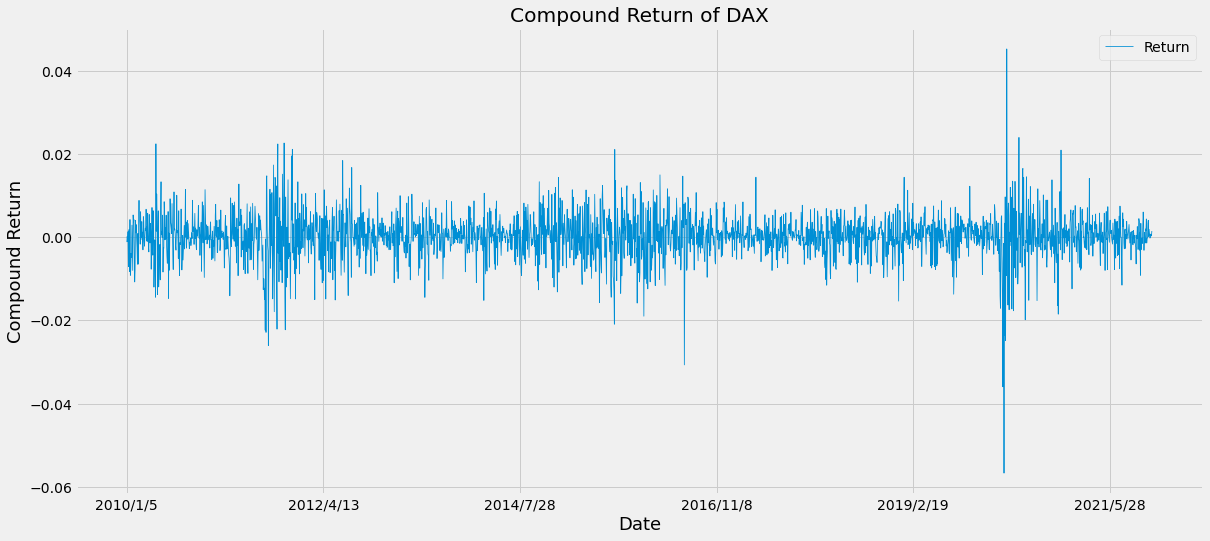

Epoch 1/100
2027/2027 [==============================] - 37s 17ms/step - loss: 0.0039
Epoch 2/100
2027/2027 [==============================] - 35s 17ms/step - loss: 0.0031 0s - loss - ETA: 0s - los
Epoch 3/100
2027/2027 [==============================] - 35s 17ms/step - loss: 0.0030
Epoch 4/100
2027/2027 [==============================] - 33s 16ms/step - loss: 0.0029 2s - loss: 0.002 - ETA: 
Epoch 5/100
2027/2027 [==============================] - 33s 16ms/step - loss: 0.0029 3s - ETA: 2s - lo - - ETA: 
Epoch 6/100
2027/2027 [==============================] - 33s 16ms/step - loss: 0.0028 0s - loss: 0.00
Epoch 7/100
2027/2027 [==============================] - 34s 17ms/step - loss: 0.0028 0s - loss: 0.002 - ETA: 0s - loss: 0. - ETA: 0s - los
Epoch 8/100
2027/2027 [==============================] - 34s 17ms/step - loss: 0.0028
Epoch 9/100
2027/2027 [==============================] - 36s 18ms/step - loss: 0.0028
Epoch 10/100
2027/2027 [==============================] - 36s 18ms/step - los

2027/2027 [==============================] - 32s 16ms/step - loss: 0.0027 1s - loss: 0.002 - ET
Epoch 84/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0027
Epoch 85/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0027 1s - loss: 0.0 - ETA: 1s - loss: 0.
Epoch 86/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0027
Epoch 87/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0027
Epoch 88/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0027  - ETA: 0s -
Epoch 89/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0027 4
Epoch 90/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0027
Epoch 91/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0027
Epoch 92/100
2027/2027 [==============================] - 32s 16ms/step - loss: 0.0027 9s - loss: 0 - ETA: 4s -  - ETA: 4s - ETA: 3s -  -  - ETA: 1s - los - 

<ipython-input-5-0f88bb993a91>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


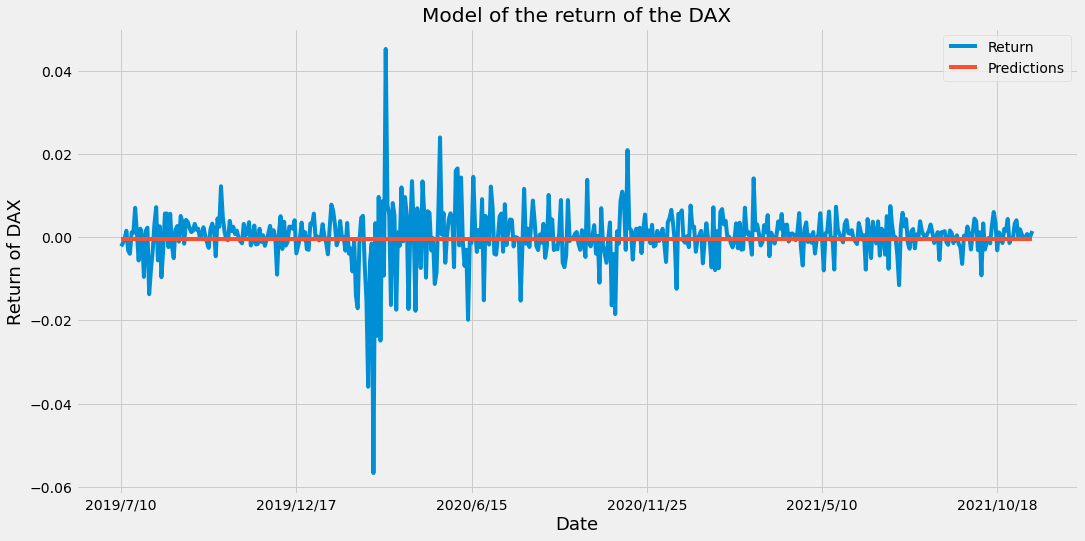

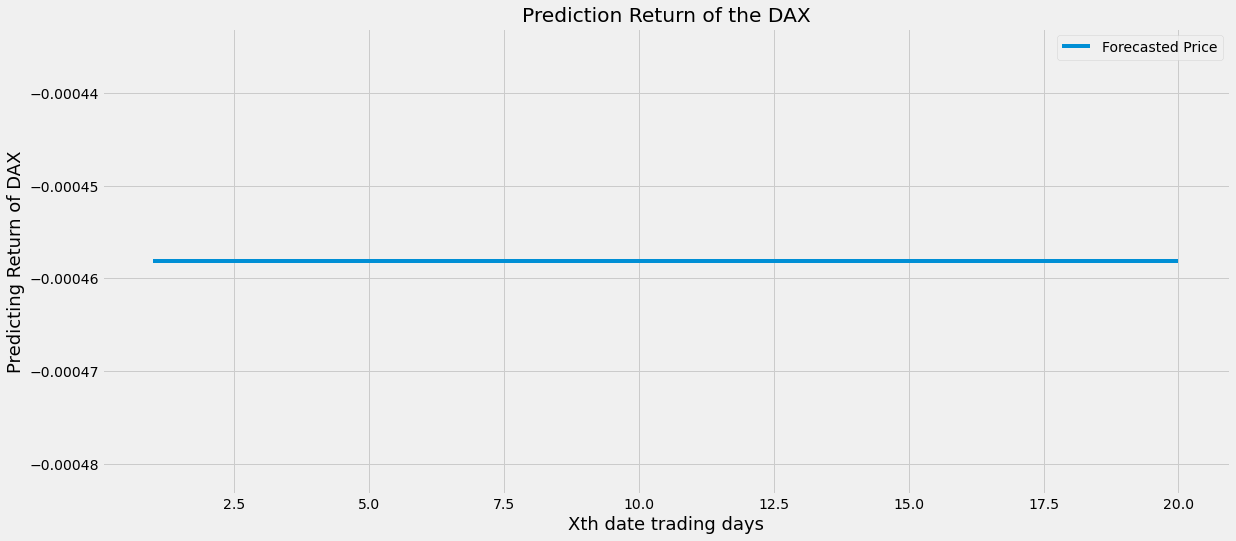

In [11]:
DAX_Return_20_days_prediction = main(DAX, 'Return', 100, 20)